# Voice Pathology Classification using SVM

This notebook implements a Support Vector Machine (SVM) model for classifying voice recordings as healthy or pathological.

## Import Libraries

In [1]:
import os
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import librosa.display
import IPython.display as ipd
from tqdm import tqdm

## Data Loading and Exploration

In [2]:
# Reading Dataset
df1 = pd.read_excel('Healthy_data.xlsx')
df2 = pd.read_excel('Pathological_data.xlsx')
df = pd.concat([df1, df2], ignore_index=True)
df = df[df.Gender == 'm']
df.head(10)

,Recording Id,Type,Gender,Age,Diagnosis Notes,Pathology,Audio
3,4,n,m,22,Normal,Normal,4-a_n.wav
4,5,n,m,22,Normal,Normal,5-a_n.wav
10,9,n,m,25,Normal,Normal,9-a_n.wav
13,11,n,m,23,Normal,Normal,11-a_n.wav
17,15,n,m,24,Normal,Normal,15-a_n.wav
29,29,n,m,58,Normal,Normal,29-a_n.wav
32,32,n,m,45,Normal,Normal,32-a_n.wav
41,40,n,m,20,Normal,Normal,40-a_n.wav
42,41,n,m,20,Normal,Normal,41-a_n.wav
44,43,n,m,32,Normal,Normal,43-a_n.wav


In [3]:
# Dataset information
print(f"Dataset shape: {df.shape}")
df.info()

Dataset shape: (561, 7)
<class 'pandas.core.frame.DataFrame'>
Index: 561 entries, 3 to 1358
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Recording Id     561 non-null    int64 
 1   Type             561 non-null    object
 2   Gender           561 non-null    object
 3   Age              561 non-null    int64 
 4   Diagnosis Notes  534 non-null    object
 5   Pathology        561 non-null    object
 6   Audio            561 non-null    object
dtypes: int64(2), object(5)
memory usage: 35.1+ KB


In [4]:
# Grouping by Type and Gender
type_gender_count = df.groupby(["Type", "Gender"])[['Audio']].count()
type_gender_count

,,Audio
Type,Gender,
n,m,259
p,m,302


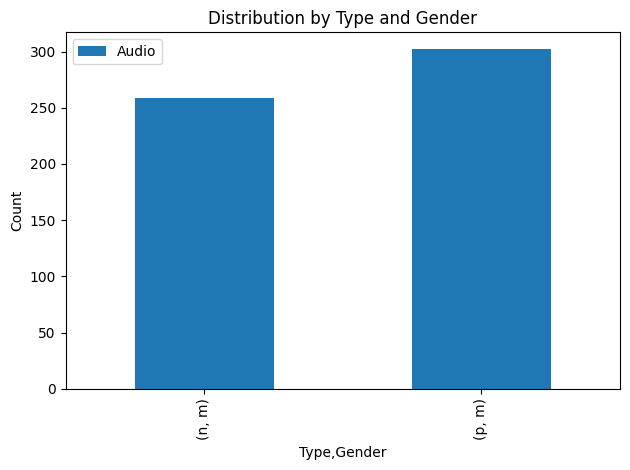

In [5]:
# Visualization
type_gender_count.plot.bar()
plt.title('Distribution by Type and Gender')
plt.ylabel('Count')
plt.tight_layout()

In [6]:
# Get unique values
gender = df.Gender.unique()
pathology = df.Pathology.unique()
print("Gender categories:", gender)
print("Pathology categories:", pathology)

Gender categories: ['m']
Pathology categories: ['Normal' 'Dysphonia' 'Laryngitis' 'Recurrent palsy']


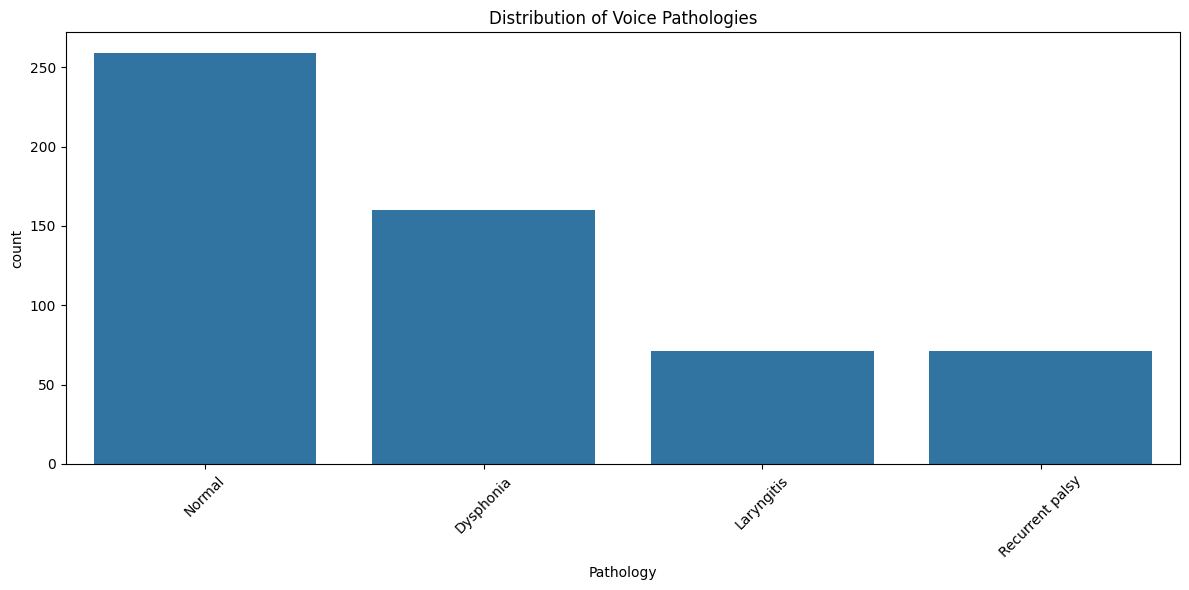

In [7]:
# Plotting pathology distribution
plt.figure(figsize=(12, 6))
sns.countplot(x=df["Pathology"])
plt.title('Distribution of Voice Pathologies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Feature Extraction

Extracting MFCC features from audio files

In [8]:
# Define feature extraction function
audio_dataset_path = 'Filtered_Audio_Dataset/'

def features_extraction(file_name):
    audio, sample_rate = librosa.load(file_name)
    mfccs_features = librosa.feature.mfcc(y=audio, n_mfcc=80)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    
    return mfccs_scaled_features

In [9]:
# Extract features from all audio files
extracted_features = []
for index_num, row in tqdm(df.iterrows()):
    file_name = audio_dataset_path + row["Audio"]
    final_class_labels = row["Type"]
    data = features_extraction(file_name)
    extracted_features.append([data, final_class_labels])

561it [00:03, 143.15it/s]


In [10]:
# Create DataFrame of extracted features
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])
extracted_features_df.head(10)

,feature,class
0,"[-279.40063, 208.50458, -43.034977, -5.3609724...",n
1,"[-172.24774, 175.08725, -75.93269, 8.991032, -...",n
2,"[-160.34766, 238.37305, -50.651234, -8.168699,...",n
3,"[-174.26555, 202.435, -48.8887, 26.138357, -21...",n
4,"[-178.27687, 191.5492, -72.104416, 7.8393016, ...",n
5,"[-197.2665, 189.61102, -47.135727, 9.000774, -...",n
6,"[-228.07173, 183.02597, -31.62691, -15.123821,...",n
7,"[-235.79805, 207.87103, -39.370476, -27.216578...",n
8,"[-332.56256, 205.95407, -61.052193, 7.679651, ...",n
9,"[-147.25774, 178.20045, -82.12582, 1.978154, -...",n


In [11]:
# Dataset shape after feature extraction
print(f"Extracted features dataframe shape: {extracted_features_df.shape}")

Extracted features dataframe shape: (561, 2)


In [12]:
# Show a sample feature
extracted_features_df["feature"][0]

array([-2.79400635e+02,  2.08504578e+02, -4.30349770e+01, -5.36097240e+00,
       -5.25304031e+01, -8.86192608e+00, -7.67323911e-01,  6.79433489e+00,
        1.07997046e+01, -1.33318496e+00,  8.67327785e+00, -7.26787519e+00,
        1.80109615e+01,  1.91590157e+01, -2.71790314e+01, -1.24479523e+01,
        1.89154112e+00, -1.52981424e+01, -4.09885502e+00,  1.89534640e+00,
        4.78107309e+00, -3.48406386e+00, -1.69791641e+01, -3.42679954e+00,
        4.22492695e+00, -9.35428524e+00, -7.85521889e+00, -2.21843690e-01,
       -7.57203770e+00, -6.02189159e+00, -9.18171024e+00,  6.11790609e+00,
        4.78465652e+00, -8.60464859e+00,  1.21054506e+01, -1.64102101e+00,
       -9.74643707e+00,  3.25917625e+00, -8.69336700e+00, -5.19987106e+00,
        3.89807367e+00, -7.44126511e+00, -5.73630333e+00, -3.99715710e+00,
       -6.73160887e+00, -3.16404700e+00, -6.69057417e+00, -3.92081738e+00,
       -3.49863482e+00, -3.57675099e+00, -3.58652568e+00, -6.14248753e+00,
       -8.73771954e+00, -

## Data Preparation

In [13]:
# Label Encoding
dummy_data = pd.get_dummies(extracted_features_df['class'])
dummy_data.head()

,n,p
0,True,False
1,True,False
2,True,False
3,True,False
4,True,False


In [14]:
# Prepare data for model
X = np.array(extracted_features_df['feature'].values.tolist())
y = dummy_data.values  # For SVM we use the actual encoded values
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (561, 80)
Labels shape: (561, 2)


In [15]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training features shape: (448, 80)
Testing features shape: (113, 80)
Training labels shape: (448, 2)
Testing labels shape: (113, 2)


## SVM Model Implementation

In [16]:
# Import necessary libraries for SVM
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from datetime import datetime

In [17]:
# We need to use StandardScaler for SVM to work effectively
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Create and train the SVM model
print("Training SVM model...")
start = datetime.now()

# We use OneVsRestClassifier for multi-label classification
svm_model = OneVsRestClassifier(SVC(kernel='rbf', probability=True, C=10))
svm_model.fit(X_train_scaled, y_train)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Training SVM model...
Training completed in time:  0:00:00.258333


In [19]:
# Evaluate the model
y_pred = svm_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.6903


In [20]:
# Generate classification report
print("\nClassification Report:")
target_names = dummy_data.columns.tolist()
print(classification_report(y_test, y_pred, target_names=target_names))


Classification Report:
              precision    recall  f1-score   support

           n       0.67      0.65      0.66        52
           p       0.71      0.72      0.72        61

   micro avg       0.69      0.69      0.69       113
   macro avg       0.69      0.69      0.69       113
weighted avg       0.69      0.69      0.69       113
 samples avg       0.69      0.69      0.69       113



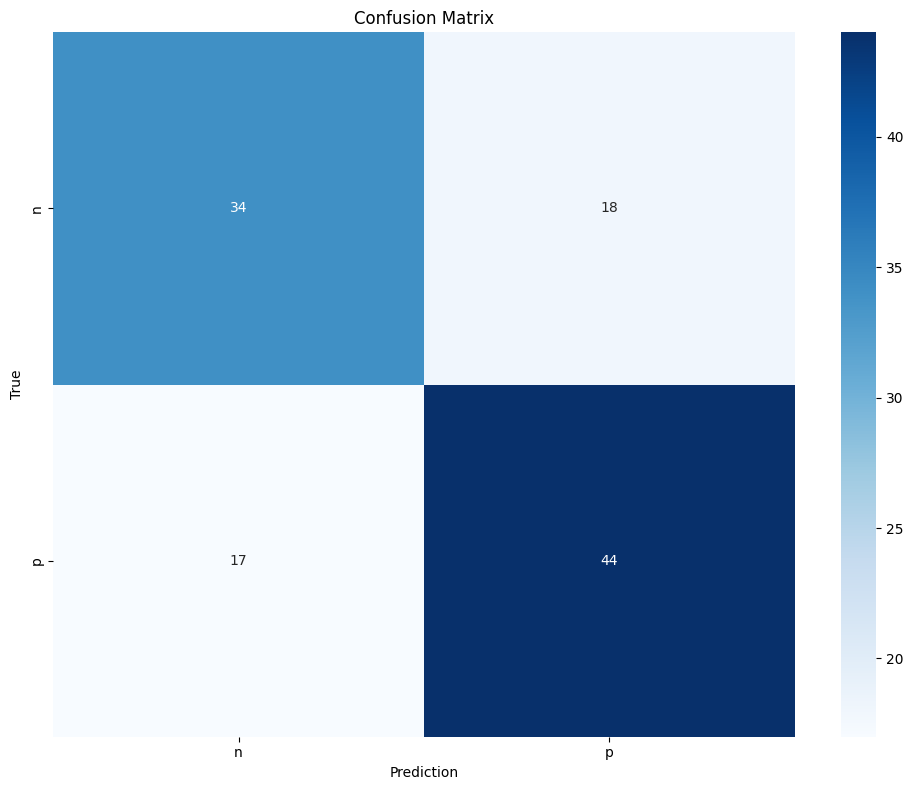

In [21]:
# Create and plot confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=target_names,
           yticklabels=target_names)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Hyperparameter Tuning

In [23]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'estimator__C': [0.1, 1, 10, 100],
    'estimator__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'estimator__kernel': ['rbf', 'poly', 'sigmoid']
}

# Create grid search
print("Starting Grid Search for SVM parameters optimization...")
grid_search = GridSearchCV(
    OneVsRestClassifier(SVC(probability=True)),
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Run grid search
grid_search.fit(X_train_scaled, y_train)

Starting Grid Search for SVM parameters optimization...
Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=SVC(probability=True)),
             n_jobs=-1,
             param_grid={'estimator__C': [0.1, 1, 10, 100],
                         'estimator__gamma': ['scale', 'auto', 0.01, 0.1, 1],
                         'estimator__kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='accuracy', verbose=1)

In [24]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Best parameters: {'estimator__C': 1, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf'}
Best cross-validation score: 0.6763


In [25]:
# Train best model
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train_scaled, y_train)

OneVsRestClassifier(estimator=SVC(C=1, gamma=0.01, probability=True))

In [26]:
# Evaluate best model
best_y_pred = best_svm_model.predict(X_test_scaled)
best_accuracy = accuracy_score(y_test, best_y_pred)
print(f"Test accuracy with optimized model: {best_accuracy:.4f}")

Test accuracy with optimized model: 0.7345


In [27]:
# Generate classification report for best model
print("\nClassification Report (Optimized Model):")
print(classification_report(y_test, best_y_pred, target_names=target_names))


Classification Report (Optimized Model):
              precision    recall  f1-score   support

           n       0.69      0.77      0.73        52
           p       0.80      0.70      0.75        61

   micro avg       0.74      0.73      0.74       113
   macro avg       0.74      0.74      0.74       113
weighted avg       0.75      0.73      0.74       113
 samples avg       0.73      0.73      0.73       113



/Users/vaibhav/This Mac/FY Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


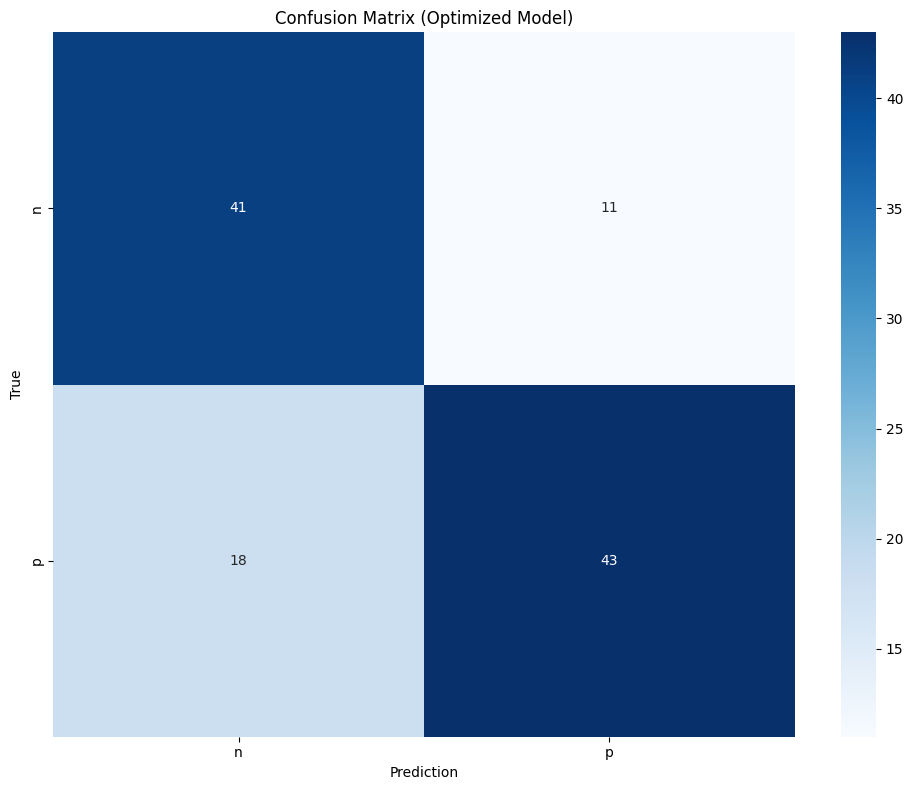

In [28]:
# Create and plot confusion matrix for best model
best_conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(best_y_pred, axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=target_names,
           yticklabels=target_names)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix (Optimized Model)')
plt.tight_layout()
plt.show()

## Model Evaluation on Sample File

In [29]:
# Test on a sample file
filename = 'Male_Female_Healthy_Dataset/1004-a_n.wav'
feature_df = pd.DataFrame(features_extraction(filename)).transpose()
features = np.array(feature_df.values.tolist())
features_scaled = scaler.transform(features)
prediction = best_svm_model.predict(features_scaled)
prediction_proba = best_svm_model.predict_proba(features_scaled)

In [30]:
# Print prediction
print("Prediction for sample file:")
predicted_class_index = np.argmax(prediction)
predicted_class = dummy_data.columns[predicted_class_index]
print(f"Predicted class: {predicted_class}")

Prediction for sample file:
Predicted class: n


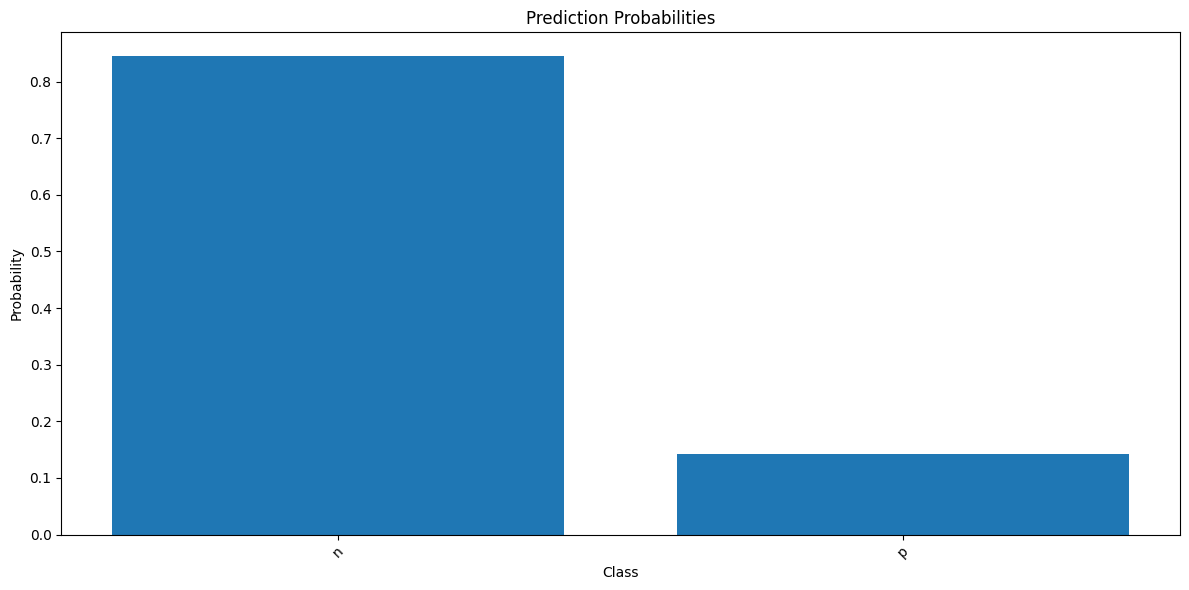

In [31]:
# Plot prediction probabilities
plt.figure(figsize=(12, 6))
plt.bar(dummy_data.columns, prediction_proba[0])
plt.title('Prediction Probabilities')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Save the Model

In [32]:
import joblib
joblib.dump(best_svm_model, 'voice_pathology_svm_model.pkl')
joblib.dump(scaler, 'voice_pathology_scaler.pkl')

['voice_pathology_scaler.pkl']

## Model Comparison (ANN vs SVM)

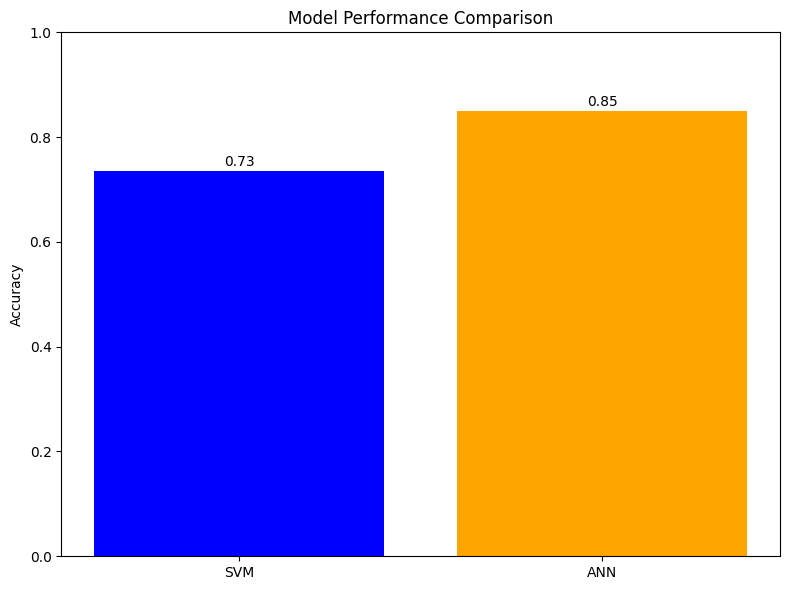

In [33]:
try:
    # Load ANN accuracy from your previous run or use a placeholder
    ann_accuracy = 0.85  # Replace with your actual ANN accuracy from previous run
    
    models = ['SVM', 'ANN']
    accuracies = [best_accuracy, ann_accuracy]
    
    plt.figure(figsize=(8, 6))
    plt.bar(models, accuracies, color=['blue', 'orange'])
    plt.ylim(0, 1.0)
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f'{v:.2f}', ha='center')
    plt.title('Model Performance Comparison')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()
except:
    print("No ANN accuracy available for comparison")

## Utility Function for Making Predictions

In [34]:
def predict_voice_pathology(file_path):
    # Extract features
    features = features_extraction(file_path)
    
    # Scale features
    features_scaled = scaler.transform([features])
    
    # Make prediction
    prediction = best_svm_model.predict(features_scaled)
    prediction_proba = best_svm_model.predict_proba(features_scaled)
    
    # Get predicted class
    predicted_class_index = np.argmax(prediction)
    predicted_class = dummy_data.columns[predicted_class_index]
    
    print(f"Predicted voice type: {predicted_class}")
    print(f"Confidence: {np.max(prediction_proba) * 100:.2f}%")
    
    # Plot probabilities
    plt.figure(figsize=(10, 6))
    plt.bar(dummy_data.columns, prediction_proba[0])
    plt.title(f'Prediction Probabilities for {os.path.basename(file_path)}')
    plt.xlabel('Voice Type')
    plt.ylabel('Probability')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return predicted_class, prediction_proba

Predicted voice type: n
Confidence: 84.48%


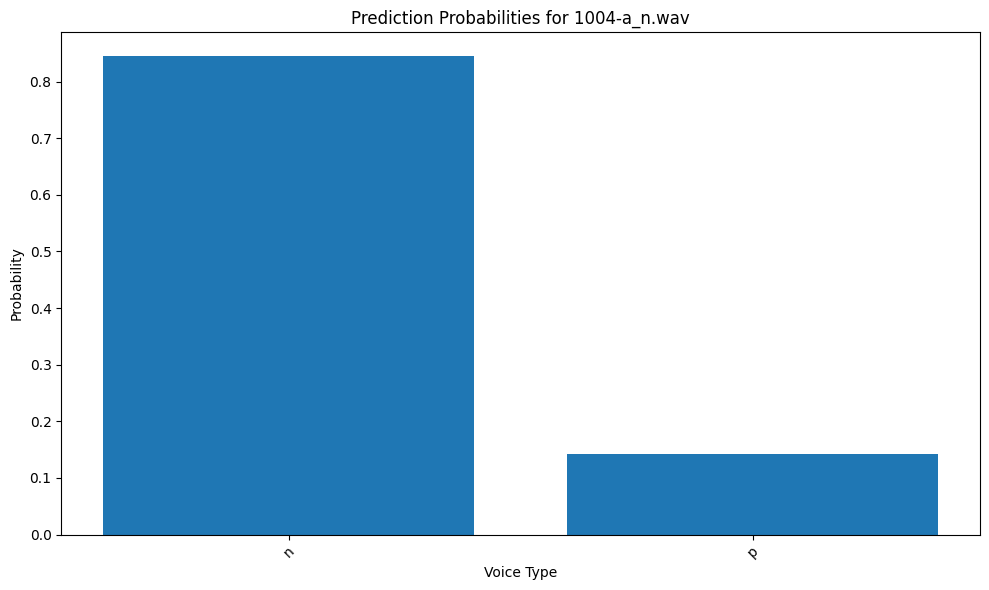

In [35]:
# Test the prediction function
test_file = 'Male_Female_Healthy_Dataset/1004-a_n.wav'
predicted_class, probabilities = predict_voice_pathology(test_file)